# KG-Grounded Conversation Generation

Authors: *Maria Diea*, *Diana Epureanu*, and *Teodora Stoenescu* <br>
Supervisor: *Svitlana Vakulenko*

Before running the notebook make you sure have the <tt> opendialkg.csv</tt> and <tt>opendialkg_triples.txt</tt> files in the same folder as your notebook. The files can be downloaded from https://github.com/facebookresearch/opendialkg/tree/master/data. <br>

Read the OpenDialKG Corpus where each dialog turn is paired with KG paths that connect its previous turn. The dataset is formatted as a csv file, where columns are: *Messages, User Rating, Assistant Rating*. <br>
Each row refers to a dialog session, which is a JSON-formatted *list* of each action. <br>
More details: https://github.com/facebookresearch/opendialkg

Make sure you have the following files:
- ```opendialkg.csv```
- ```opendialkg_triples.txt```
- ```kanye_west.csv```
- ```got.csv```
- ```shrek.csv```
-```ranker_input_pruned.pkl```

The following files are optional but can be used to avoid re-training the models:
- ```BiOpenDialKG.csv``` (pre-process dataset)
- ```best_model_state.bin``` (pre-trained classifier)
- ```output-finetuned``` (finetuned DialoGPT)


Set up your working directory if needed.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Import libraries, initiliaze devices and datasets. 

In [3]:
!pip install transformers

In [4]:
import numpy as np
import pandas as pd
from pylab import rcParams
from toolz import interleave
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast
import re

import transformers
from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoModelWithLMHead,
    AutoTokenizer,
    BertModel, 
    BertTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv('opendialkg.csv')

# prune the dataset such that we only have the highest rated dialogues
top_rating = df['User Rating'][0]  # hard coded - the first entry has maximum scores
df = df[df['User Rating'] == top_rating]
df = df[df['Assistant Rating'] == top_rating]

In [6]:
triples_df = pd.read_csv("opendialkg_triples.txt", 
                         sep='\t', 
                         names=['Subject', 'Relation', 'Object'])
triples_df.dropna(inplace=True)
triples_df['Relation'] = triples_df['Relation'].apply(lambda x: x[1:] if '~' in x else x)

In [7]:
triples_df.dropna(inplace=True)
all_entities = set(triples_df['Subject'].values.tolist() + triples_df['Object'].values.tolist())
print('There are {0} entities in the knowledge graph.'.format(len(all_entities)))

There are 100716 entities in the knowledge graph.


---

Set ```LOAD_PRE_DATASET```, ```LOAD_CLASSIFIER```, or ```LOAD_FINETUNED``` to True if you would like to use the already pre-processed data, the pre-trained classifier, or the already finetuned DialoGPT.

Set ```DIALOGPT_FINETUNED``` to True if you are not using the already finetuned DialoGPT but you would like to finetune it here.

In [8]:
LOAD_PRE_DATASET = True
LOAD_CLASSIFIER = False
LOAD_FINETUNED = True

ONLY_POSITIVE_TEST = False  # use only positive test instance for classifier test
PAIRED_DATA = False  # pair up data such that for every positive instance there is a negative one
PRE_PROCESSED_DATA = 'BiOpenDialKG.csv'  
CLASSIFIER_MODEL = 'best_model_state.bin'
FINETUNED_MODEL = 'output-finetuned'
DIALOGPT_CARD = 'microsoft/DialoGPT-medium'
DIALORPT_CARD = 'microsoft/DialogRPT-depth'

# load bert model and tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
class BinaryClassifier(nn.Module):
  def __init__(self, n_classes):
    super(BinaryClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes, bias=False)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    
    return torch.sigmoid(self.out(output))

In [10]:
classifier = BinaryClassifier(2)
classifier = classifier.to(device)
EPOCHS = 1
  
if LOAD_PRE_DATASET:
  # load the pre-procssed dataset
  train_df = pd.read_csv(PRE_PROCESSED_DATA)
  train_df.drop(['Unnamed: 0'], axis=1, inplace=True)

  # show more of the text message
  pd.set_option('display.max_colwidth', None)

  # remove nans, if any
  train_df = train_df.dropna()
  print(train_df.isnull().sum())

  if PAIRED_DATA:
    col_names = list(train_df.columns)
    data_positive = train_df[train_df["Label"] == 1]
    data_negative = train_df[train_df["Label"] == 0]
    train_df = pd.DataFrame(interleave([data_positive.values, data_negative.values]))
    train_df.columns = col_names

if LOAD_CLASSIFIER:
  classifier.load_state_dict(torch.load(CLASSIFIER_MODEL, map_location=device))

if LOAD_FINETUNED:
  generator_model = AutoModelWithLMHead.from_pretrained(FINETUNED_MODEL)
  generator_tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL)
else:
  generator_model = AutoModelWithLMHead.from_pretrained(DIALOGPT_CARD)
  generator_tokenizer = AutoTokenizer.from_pretrained(DIALOGPT_CARD)

ranker_tokenizer = AutoTokenizer.from_pretrained(DIALORPT_CARD)
ranker_model = AutoModelForSequenceClassification.from_pretrained(DIALORPT_CARD)

Message     0
Subject     0
Relation    0
Object      0
Label       0
dtype: int64


/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:825: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


### Data Preparation
Either run these cells or load the already pre-processed dataset above. 

!! Choose between random or distribution based negative sampling.

#### Positive Sampling

To sample positive entities, we look at the messages provided in the OpenDialKG and extract the entities present in the dialogue.

In [35]:
train_df = pd.DataFrame(columns=['Message', 'Subject', 'Relation', 'Object', 'Label'])
opendialkg = dict()  # data structure to hold the dialog history; indexed by integers

for d, dialogue in enumerate(df['Messages']):
    opendialkg[d], r = [], 0  # dialogue d history and reply number
    dialogue = ast.literal_eval(dialogue)  # format string to list
    
    for response in dialogue:
        response = dict(response)
        
        # each reply in a dialogue is either a message or metadata
        if 'message' in response:
            opendialkg[d].append(response['message']) # record reply
            r += 1
            
        if 'metadata' in response:
            # make sure the kg path is available
            if 'path' in response['metadata']:
                if r == 0:
                    # metadata is the first dialogue line, out of the ordinary
                    continue
                
                # usually metadata directly follows the message
                message = opendialkg[d][r-1]
                
                for sbj, rel, obj in response['metadata']['path'][1]:
                    # for consistency: select only entities which are directly reffered in the previous message
                    if sbj in message:
                        if '~' in rel:
                            rel = rel[1:]  # relations randomly have a '~' symbol
                        train_df = train_df.append({'Message': message, 
                                                    'Subject': sbj, 
                                                     'Relation': rel, 
                                                     'Object': obj, 
                                                     'Label': 1}, ignore_index=True)
                        
                        opendialkg[d][r-1] = (opendialkg[d][r-1], (sbj, rel, obj))

#### Negative Sampling


###### Distribution-based

Get distribution of relations for every entity.

In [15]:
from tqdm import tqdm

# create set of entities 
entities = list(train_df["Subject"].unique())
 
entityToPredicateDict = dict()
# creates dict with the following shape:
""""
 {entity_1: {relation1 : #occurences, ..., relation_n : #occurences}
 ...
 entity_n : {relation1 : #occurences, ..., relation_n : #occurences}
 }
"""
for entity in tqdm(entities):
    
    df_entity = train_df[train_df["Subject"] == entity]
    
    predDistPerEntity = defaultdict(int)
    
    for index, row in df_entity.iterrows():
        
        relation = row["Relation"]
        
        predDistPerEntity[relation] = predDistPerEntity[relation] + 1
        
    entityToPredicateDict[entity] = predDistPerEntity    

100%|██████████| 3539/3539 [00:03<00:00, 907.23it/s]


Get global distribution of relations.

In [16]:
# create set of relations 
relations = list(train_df["Relation"].unique())
 
globalRelationDict = defaultdict(int)

# creates dict with the following shape (based on entityToPredicateDict):
""""
 {relation_1: #occurences
 ...
 relation_n : #occurences
 }
"""
for entity in entityToPredicateDict:
    
    predDist = entityToPredicateDict[entity]
    
    for relation, count in predDist.items():
        
        globalRelationDict[relation] = globalRelationDict[relation] + count

Get distribution of objects for each subject

In [17]:
# create set of relations
subjects = list(train_df["Subject"].unique())

# create set of objects
objects = list(train_df["Object"].unique())

subjectToObjectDict = dict()

#creates dict with the following shape

"""
{subject_1: {object1 : #occurences, ..., object_n : #occurences}
 ...
 subject_n : {object1 : #occurences, ..., object_n : #occurences}
 }

"""

for subject in tqdm(subjects):
    
    df_subject = train_df[train_df["Subject"] == subject]
    
    objectDistPerSubject = defaultdict(int)
    
    for index, row in df_subject.iterrows():
        
        object_ = row["Object"]
        
        objectDistPerSubject[object_] = objectDistPerSubject[object_] + 1
        
    subjectToObjectDict[subject] = objectDistPerSubject

100%|██████████| 3539/3539 [00:03<00:00, 921.95it/s] 


We aim to generate negative samples such that the dataset is balanced. Therefore, for each message among the positive samples we inspect the entity and append the predicate and the object according to the following strategy: 
Predicates have a global distribution as well as a local distribution according to the entity they accompany. We want to append a globally frequent, but locally infrequent predicate to each entity in order to emphasize the difference between appropriate and inappropriate entity-predicate combinations. As for the objects, we append the most frequent ones which accompany the chosen predicate.

Notes: The object was initially selected based on the distribution according to the selected predicate. However, this leads to learning truth entries instead of relevant entries. Thus, both the subject and the predicate should be incorporated in choosing the object. Distributions based on subject-predicate are scarse for most of the pairs, therefore we sticked to choosing the object based on the distribution according to the subject.

In [20]:
import random

neg_candidates = pd.DataFrame(columns=['Message', 'Subject', 'Relation', 'Object', 'Label'])

most_frequent_global_relations = [ entry[0] for entry in sorted(globalRelationDict.items(), reverse=True)]

def find_negative_predicate(entity):
    
    most_frequent_local_relations = [entry[0] for entry in sorted(entityToPredicateDict[entity].items(), reverse=True)]
    most_frequent_globals_not_in_local = [entry for entry in most_frequent_global_relations if entry not in most_frequent_local_relations]
    random_choice_most_frequent = random.choice(most_frequent_globals_not_in_local[:10])
    
    return random_choice_most_frequent

def find_negative_object(positive_object, subject):
    
    most_frequent_objects = [entry[0] for entry in sorted(subjectToObjectDict[subject].items(), reverse=True)]
    
    if positive_object in most_frequent_objects:
        
        most_frequent_objects.remove(positive_object)
        
    if len(most_frequent_objects) == 0:
        
        globalObjects = list(train_df["Object"].unique())
        
        if positive_object in globalObjects:
            
            globalObjects.remove(positive_object)
            
            return globalObjects[0]
  
    return most_frequent_objects[0]
    

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    
    message = row["Message"]
    subject = row["Subject"]
    positive_object = row["Object"] # make sure we do not use the same object for negative sample
    label = 0
    
    negative_predicate = find_negative_predicate(subject)
    negative_object = find_negative_object(positive_object, subject)
    
    neg_candidates = neg_candidates.append({'Message': message, 
                                            'Subject': subject, 
                                            'Relation': negative_predicate, 
                                            'Object': negative_object, 
                                            'Label': label}, ignore_index=True)
    

100%|██████████| 7827/7827 [00:31<00:00, 251.53it/s]


In [39]:
train_df = train_df.append(neg_candidates)

##### Random
For negative samples we randomly extract entities surrounding the subject-entity that have not been part of the conversation.
Start by reading the triple dataset which has the form: *subject relation object*. Initialize every entry as a negative sample.<br>
More details: https://github.com/facebookresearch/opendialkg

In [ ]:
triples_df['Relation'] = triples_df['Relation'].apply(lambda x: x[1:] if '~' in x else x)
triples_df['Label'] = 0
triples_df['Message'] = ''
triples_df = triples_df[['Message', 'Subject', 'Relation', 'Object', 'Label']]
triples_df

For every positive sample $(message, sbj_1, rel_1, obj_1)$ we are looking to sample negative examples $(message, sbj_1, rel_2, obj_2)$ such that $obj_1 \not= obj_2$.<br>
For every positive example, sample *n_samples* negative ones. *Default: 5* <br>
*Note:* This cell will take ~15 mins. to run.

In [ ]:
n_samples = 5
neg_candidates = pd.DataFrame(columns=['Message', 'Subject', 'Relation', 'Object', 'Label'])

# each message-subject pair may appear multiple times with different objects
for message, sbj in tqdm(train_df[['Message', 'Subject']].drop_duplicates().values.tolist()):
    # we must make sure that we do not have contradicting entries
    objs = train_df[(train_df['Message'] == message) &
                    (train_df['Subject'] == sbj)]['Object']
    
    cand = triples_df[(triples_df['Subject'] == sbj) &
                      (~triples_df['Object'].isin(objs))]
    cand = cand.sample(min(n_samples, len(cand)))
    cand['Message'] = message
    
    neg_candidates = neg_candidates.append(cand)

In [ ]:
train_df = train_df.append(neg_candidates)

### Classifier
This block is used to train the classifier. If the classifier is pre-loaded, no need to run it.

#### Pre-process data

In [11]:
if PAIRED_DATA:
    col_names = list(train_df.columns)
    data_positive = train_df[train_df["Label"] == 1]
    data_negative = train_df[train_df["Label"] == 0]
    train_df = pd.DataFrame(interleave([data_positive.values, data_negative.values]))
    train_df.columns = col_names

In [12]:
# merge message, subject, relation, object as indicated
data = pd.DataFrame()
data["Message"] = train_df["Message"] +  " [SEP] " + train_df["Relation"] + " [SEP] " + train_df["Object"]
data["Label"] = train_df["Label"]
data.head()

,Message,Label
0,Do you like Iron Man [SEP] starred_actors [SEP] Robert Downey Jr.,1
1,Sure do! Robert Downey Jr. is a favorite. [SEP] starred_actors [SEP] Zodiac (Crime Fiction Film),1
2,I like crime fiction! Didn't know RDJ was in there. Jake Gyllenhaal starred as well. [SEP] starred_actors [SEP] End of Watch,1
3,So he did he also starred in End of Watch have you ever seen that movie? [SEP] has_genre [SEP] Thriller,1
4,Do you like Michael Jackson? [SEP] written_by [SEP] Dancing the Dream,1


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


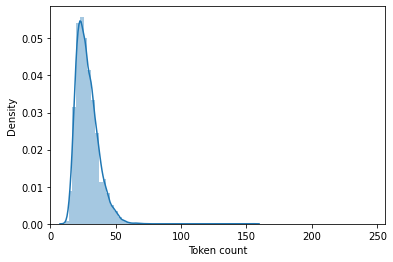

In [13]:
# check distribution of tokens in order to set the maximum length of the encoded sequence
# this is because bert needs to have the input sequences of the same length. 
# It uses [PAD] tokens to reach the MAX_LEN 
token_lens = []

for msg in data.Message:
  tokens = tokenizer.encode(msg)
  token_lens.append(len(tokens))

# plot distribution of token lengths  
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');  

In [14]:
MAX_LEN = 65

In [15]:
# split into train, validation and test
if PAIRED_DATA:
  data_train, data_val, data_test = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
else:  
  data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
  data_val, data_test = train_test_split(data_test, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

if ONLY_POSITIVE_TEST:
  data_val = data_val[data_val["Label"] == 1]
  data_test = data_test[data_test["Label"] == 1]

In [16]:
# helper class for storing the data
class OpenDialKGDataset(Dataset):
  def __init__(self, messages, labels, tokenizer, max_len):
    self.messages = messages
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.messages)
  
  def __getitem__(self, item):
    message = str(self.messages[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      message,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'message': message,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }


# loader function for the above class
def create_data_loader(df, tokenizer, max_len=65, batch_size=16):
  dataset = OpenDialKGDataset( messages=df.Message.to_numpy(), 
                         labels=df.Label.to_numpy(), 
                         tokenizer=tokenizer,
                         max_len=max_len)

  return DataLoader(dataset, batch_size=batch_size)

In [17]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
  true_labels_list = []
  predicted_labels_list = []
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i,d in enumerate(data_loader):
    optimizer.zero_grad()

    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)

    true_labels = labels.cpu().numpy()
    predicted_labels = outputs[:, 1].detach().cpu().numpy()
    predicted_args = preds.cpu().numpy()

    true_labels_list = true_labels_list + true_labels.tolist()
    predicted_labels_list = predicted_labels_list + predicted_labels.tolist()

    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)

    losses.append(loss.item())
    if (i%100==0):
      print(f"{i} out of {len(train_data_loader)}")

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()


  return correct_predictions.double() / n_examples, np.mean(losses), true_labels_list, predicted_labels_list

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  true_labels_list = []
  predicted_labels_list = []
  predicted_args_list = []

  with torch.no_grad():
    for i, d in enumerate(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      _, preds = torch.max(outputs, dim=1)

      true_labels = labels.cpu().numpy()
      predicted_labels = outputs[:, 1].cpu().numpy()
      predicted_args = preds.cpu().numpy()

      true_labels_list = true_labels_list + true_labels.tolist()
      predicted_labels_list = predicted_labels_list + predicted_labels.tolist()
      predicted_args_list = predicted_args_list + predicted_args.tolist()

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)

      losses.append(loss.item())


  return correct_predictions.double() / n_examples, np.mean(losses), true_labels_list, predicted_labels_list, predicted_args_list

In [20]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE) 

In [22]:
EPOCHS = 1

optimizer = AdamW(classifier.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('----------')

  train_acc, train_loss, train_tl, train_pl = train_epoch(classifier, train_data_loader, loss_fn, optimizer, device, len(data_train))
  print(f'Train loss = {train_loss},  Accuracy =  {train_acc}')

  val_acc, val_loss, true_labels, predicted_labels, predicted_args = eval_model(classifier, val_data_loader, loss_fn, device, len(data_val))
  print(f'Validation loss = {val_loss},  Accuracy {val_acc}')
  
  print()

  if val_acc > best_accuracy:
    torch.save(classifier.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0 out of 783
100 out of 783
200 out of 783
300 out of 783
400 out of 783
500 out of 783
600 out of 783
700 out of 783
Train loss = 0.4319654333941629,  Accuracy =  0.8812300319488818
Validation loss = 0.40592806710272417,  Accuracy 0.9073482428115016



In [24]:
test_acc, _, true_labels, predicted_scores, predicted_labels = eval_model(classifier, test_data_loader, loss_fn, device, len(data_test))

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.9150159744408946

#### Classifier Results

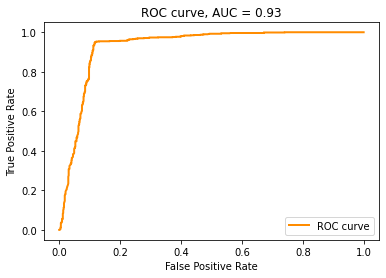

In [25]:
fpr, tpr, thresholds = roc_curve(np.asarray(true_labels), np.asarray(predicted_scores), pos_label=1)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr, color='darkorange', lw = 2, label='ROC curve', clip_on=False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, AUC = %.2f'%auc)
plt.legend()
plt.show() 

In [61]:
#Let's look at the false positive and false negative cases
"""
1. False positive: Get indices where pred_label = 1 and true_label = 0
2. False negative: Get indices where pred_label = 0 and true_label = 1
"""
false_positives = [0] * len(true_labels)
false_negatives = [0] * len(true_labels)
tp, tn = 0, 0

for i in range(len(true_labels)):
  if true_labels[i] == 1 and predicted_labels[i] == 1:
    tp += 1
  if true_labels[i] ==0 and predicted_labels[i] ==0:
    tn += 1
  if true_labels[i] == 0 and predicted_labels[i] == 1:
    false_positives[i] = 1
  if true_labels[i] == 1 and predicted_labels[i] == 0:
    false_negatives[i] = 1  

dataset_fp = data_test.iloc[np.where(false_positives)[0].tolist()]
dataset_fn = data_test.iloc[np.where(false_negatives)[0].tolist()]

In [62]:
import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix", fontsize=16)
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="Blues", cbar=False)
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()
 
# define data
total = (tp + tn + len(dataset_fn) + len(dataset_fp)) / 100
data = [[tp / total, len(dataset_fn) / total],
        [len(dataset_fp) / total , tn / total]]
 
# define labels
labels = ["Relevant", "Irrelevant"]
 
# create confusion matrix
plot_confusion_matrix(data, labels, "confusion_matrix.png")

Text(0, 0.5, 'Prediction Score')

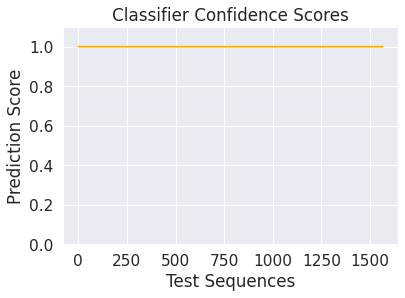

In [63]:
#Classification threshold
score = []

for label in predicted_labels:
  score.append(max(label, 1-label))

plt.ylim((0, 1.1))
plt.plot(score, c='orange')
plt.title("Classifier Confidence Scores")
plt.xlabel("Test Sequences")
plt.ylabel("Prediction Score")

### DialoGPT

This section is used to finetune the GPT-2 model on the OpenDialKG dataset (can be skipped if *finetuned_model.bin* is available)

To finetune the model we followed the following tutorial by  Rostyslav Neskorozhenyi <br> 
Article: https://towardsdatascience.com/make-your-own-rick-sanchez-bot-with-transformers-and-dialogpt-fine-tuning-f85e6d1f4e30 <br>
Code: https://colab.research.google.com/drive/15wa925dj7jvdvrz8_z3vU7btqAFQLVlG

#### Data preparation

Please run the Data Prepation block above such that *opendialkg* is built. 

In [64]:
finetune_df = []

for i in opendialkg:
  for j in range(0, len(opendialkg[i]) - 1):
    response = opendialkg[i][j+1][0] if (type(opendialkg[i][j+1]) == tuple) else opendialkg[i][j+1]
    context = opendialkg[i][j][0] if (type(opendialkg[i][j]) == tuple) else opendialkg[i][j]
    finetune_df.append({'response': response,
                        'context': context,
    })

finetune_df = pd.DataFrame(finetune_df)
finetune_df

,response,context
0,Sure do! Robert Downey Jr. is a favorite.,Do you like Iron Man
1,Yes i like him too did you know he also was in...,Sure do! Robert Downey Jr. is a favorite.
2,I like crime fiction! Didn't know RDJ was in t...,Yes i like him too did you know he also was in...
3,So he did he also starred in End of Watch have...,I like crime fiction! Didn't know RDJ was in t...
4,Yes I have! I like films directed by David Aye...,So he did he also starred in End of Watch have...
...,...,...
29384,Another recommendation is The Legend of Hercules.,That's a good one! Do you know of any others?
29385,"I haven't seen that one, do you know who stars...",Another recommendation is The Legend of Hercules.
29386,Kellan Lutz stars in the film.,"I haven't seen that one, do you know who stars..."
29387,"Oh alright! I think I'm sold on that one, than...",Kellan Lutz stars in the film.


In [65]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.max_len - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

#### Training

In [66]:
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [67]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output-finetuned'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [68]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [69]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

#### Run

In [70]:
# Main runner
def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results, model

In [71]:
trn_df, val_df = train_test_split(finetune_df, test_size = 0.1)
main(trn_df, val_df)
generator_model = AutoModelWithLMHead.from_pretrained(FINETUNED_MODEL)
generator_tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL)

10/23/2020 15:50:32 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
10/23/2020 15:50:33 - INFO - filelock -   Lock 140203072038728 acquired on cached/8833f19dc2d2e7283d03d94f879e592e5512320f1a1f2c02f0365e8083441740.92596f8e95f12e3301753009c5c280b3d6e4f5861fcda63c97cf496529703153.lock


10/23/2020 15:50:33 - INFO - filelock -   Lock 140203072038728 released on cached/8833f19dc2d2e7283d03d94f879e592e5512320f1a1f2c02f0365e8083441740.92596f8e95f12e3301753009c5c280b3d6e4f5861fcda63c97cf496529703153.lock


10/23/2020 15:50:34 - INFO - filelock -   Lock 140203072038280 acquired on cached/160770c7e6068191582afd6748b1f7e8395a4e6e63264fa390d534c6e25184b9.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock


10/23/2020 15:50:35 - INFO - filelock -   Lock 140203072038280 released on cached/160770c7e6068191582afd6748b1f7e8395a4e6e63264fa390d534c6e25184b9.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock


10/23/2020 15:50:35 - INFO - filelock -   Lock 140203072037776 acquired on cached/2768fc6cab7211630a47d239a3c467e01b5edcc650491f3777f181979ed61486.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


10/23/2020 15:50:36 - INFO - filelock -   Lock 140203072037776 released on cached/2768fc6cab7211630a47d239a3c467e01b5edcc650491f3777f181979ed61486.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:825: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
10/23/2020 15:50:38 - INFO - filelock -   Lock 140201760401392 acquired on cached/dfce0c30714b109db92d119a65f60c177b0307b001aaeab3acb46baa6fd83caf.d62bc4460f435335df940faeff855fa04937181751e23f4db6ef38919d948abc.lock


10/23/2020 15:52:06 - INFO - filelock -   Lock 140201760401392 released on cached/dfce0c30714b109db92d119a65f60c177b0307b001aaeab3acb46baa6fd83caf.d62bc4460f435335df940faeff855fa04937181751e23f4db6ef38919d948abc.lock


10/23/2020 15:52:20 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x7f83924700f0>
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1374: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
10/23/2020 15:52:20 - INFO - __main__ -   Creating features from dataset file at cached
10/23/2020 15:52:34 - INFO - __main__ -   Saving features into cached file cached/gpt2_cached_lm_512
10/23/2020 15:52:34 - INFO - __main__ -   ***** Running training *****
10/23/2020 15:52:34 - INFO - __main__ -     Num examples = 26450
10/23/2020 15:52:34 - INFO - __main__ -     Num Epochs = 3
10/23/2020 15:52:34 - INFO - __main__ -     Instantaneous batch size per GPU = 4
10/23/2020 15:52:34 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 4
10/23/2020 15:52:34 - INFO - __main__ -     Gradient Accumulation steps = 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


KeyboardInterrupt: ignored

### Main

These are some helper function to combine every module of the pipeline.

First, given a dialog context **x** = $\{x_1,...,x_n\}$, extract the seed entity **s** $\in$ **x** and determine *k* candidate entities from the knowledge graph. 

In [72]:
def seed_entity(dialog_context):
  seed = ''

  for entity in all_entities:
    try:
      if (re.search(r'\b{}\b'.format(entity), dialog_context)) and len(seed) < len(entity):
        seed = entity
    except:
      continue
      
  return seed


def build_candidates(dialog_context, k=50):
  """
  Randomly choose k entities from the 1-hop neighbourhood of the seed entity.
  """
  seed = seed_entity(dialog_context)

  if seed == '':
    print('Seed entity not found.')
    return None
  else:
    print('Seed entity: {}'.format(seed))

  mask = triples_df['Subject'] == seed
  candidates = triples_df[mask][['Relation', 'Object']].drop_duplicates()
  candidates = candidates.sample(min(len(candidates), k))

  candidates['Message'] = dialog_context + ' [SEP] ' + candidates['Relation'] + ' [SEP] ' + candidates['Object']
  candidates['Label'] = 1  # artificially impute it
  candidates = candidates[['Message', 'Label']]

  return candidates

Generate responses by inputing the object entity at the beginning of each sentence.

In [73]:
import random

def generate_responses(tokenizer, model, conversations):
  user_input = conversations['Message'].tolist()
  start_entities = conversations['Object'].tolist()

  responses = []

  for step in range(len(conversations)):
      # encode the user input, add the eos_token, add the beginning entity of the generator and return a tensor in Pytorch
      user_turn = tokenizer.encode(user_input[step] + tokenizer.eos_token + start_entities[step], return_tensors='pt')
      
      # generated a response   
      response = model.generate(
      user_turn, max_length=1000,
      pad_token_id=tokenizer.eos_token_id
      )

      decoded_response = tokenizer.decode(response[0], skip_special_tokens=True)
      full_response = start_entities[step] + decoded_response[-(len(decoded_response) - len(user_input[step]) - len(start_entities[step])):]

      responses.append(full_response)

  return responses

Then re-rank these responses.

In [16]:
def score(cxt, hyp, tokenizer, model):
  model_input = tokenizer.encode(cxt + "<|endoftext|>" + hyp, return_tensors="pt")
  result = model(model_input, return_dict=True)
  return torch.sigmoid(result.logits)
  
def rank_responses(ranker_tokenizer, ranker_model, dialogue_context, responses):
  scores = []

  for i, response in enumerate(responses):
    scores.append(score(dialogue_context, response, ranker_tokenizer, ranker_model).squeeze().item())

  return sorted(zip(scores, responses), key=lambda x: x[0], reverse=True)

---


This is the main code block. Use this to interact with the system.

In [75]:
text = input("User: ")
top_k = 40  


def build_responses(dialog_context):
    candidates = build_candidates(dialog_context) 

    if candidates is None:
      print('Seed entity not found. Try another sentence.')
      return

    cand_loader = create_data_loader(candidates, tokenizer, MAX_LEN, BATCH_SIZE) 
    _, _, _, predicted_scores, predicted_labels = eval_model(classifier, cand_loader, loss_fn, device, len(data_test))

    top_scores = sorted(zip(range(len(predicted_scores)), predicted_scores), key=lambda x: x[1], reverse=True)[:top_k]

    candidates.reset_index(drop=True, inplace=True)

    dialogpt_cand = []
    for i, pred in top_scores:
      m, _, o = candidates['Message'][i].split('[SEP]')
      dialogpt_cand.append({
          'Message': m,
          'Object': o,
          'Predictions': pred
      })

    dialogpt_cand = pd.DataFrame(dialogpt_cand)
    responses = generate_responses(generator_tokenizer, generator_model, dialogpt_cand)

    return rank_responses(ranker_tokenizer, ranker_model, text, responses), predicted_labels

ranked_responses, _ = build_responses(text)
print("Bot: ", ranked_responses[0][1])

User: Do you like Iron Man?
Seed entity: Iron Man


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Bot:   House of M, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man, Iron Man


### Analysis

#### Quantitative metrics (entity-F1, recall@k)

To compare our method to the baseline, we measure the entity-F1 score for entity prediction (KG-copy network) and recall@k (OpenDialKG) for k = 1, 3, 5, 10, 25.

To make this experiment, we pick three seed entities who have between 40-50 neighbours in the Knowledge Graphs and for each of them, we build an artifical dialog context:<br>
*Kanye West* is a great songwriter. <br>
*Game of Thrones* is my favourite series. <br>
*Shrek Forever After* is such a fun movie. 

We manually annotate each dialogue context's candidate entities as being relevant and irrelevant and we compare these results to the results of the system. 

We run this experiment both on the base model and the fine-tuned one.

Make sure you have the following files in your working directory:
- ```kanye_west.csv```
- ```got.csv```
- ```shrek.csv```

In [76]:
eval_data = [('Kanye West is a great songwriter.', 'kanye_west.csv'),
             ('Game of Thrones is my favourite series.', 'got.csv'),
             ('Shrek Forever After is such a fun movie.', 'shrek.csv')
]

r_1, r_3, r_5, r_10, r_25 = [], [], [], [], []
predictions = []
ground_truth = []

for dialog_context, csv_file in eval_data:
  print("Running experiment for...")
  print(dialog_context)

  responses, predicted_labels = build_responses(dialog_context)
  predictions.append(predicted_labels)
  responses = [r[1] for r in responses]

  test_df = pd.read_csv(csv_file)
  test_df = test_df[['Subject', 'Object', 'Label']]
  candidate_objects = list(test_df['Object'].unique())
  ground_truth.append(test_df['Label'].values.tolist())

  total_relevant = test_df['Label'].sum()
  rel = 0

  for k, response in enumerate(responses):
      seed = ''
      for obj in candidate_objects:
        try:
          if (re.search(r'\b{}\b'.format(obj), response)) and len(seed) < len(obj):
            seed = obj
        except:
          continue
      
      relevancy = test_df[(test_df['Object'] == seed) & (test_df['Label'] == 1)].drop_duplicates()['Label'].unique()

      if len(relevancy) == 1:
        rel += 1

      if k == 0:
         r_1.append(rel / total_relevant * 100)
      if k == 2:
         r_3.append(rel / total_relevant * 100)
      if k == 4:
         r_5.append(rel / total_relevant * 100)
      if k == 9:
         r_10.append(rel / total_relevant * 100)
      if k == 24:
         r_25.append(rel / total_relevant * 100)

Running experiment for...
Kanye West is a great songwriter.
Seed entity: Kanye West


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Running experiment for...
Game of Thrones is my favourite series.
Seed entity: Game of Thrones


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Running experiment for...
Shrek Forever After is such a fun movie.
Seed entity: Shrek Forever After


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [77]:
print('Recall@1:', sum(r_1) / 3)
print('Recall@3:',  sum(r_3) / 3)
print('Recall@5:',sum(r_5) /3 )
print('Recall@10:',  sum(r_10) / 3)
print('Recall@25:',  sum(r_25) /3 )

Recall@1: 5.619658119658119
Recall@3: 11.730769230769232
Recall@5: 17.072649572649574
Recall@10: 20.128205128205128
Recall@25: 60.85470085470086


In [78]:
true_pos, false_pos, false_neg = 0, 0, 0

for i in range(len(predictions)):
  for j in range(len(predictions[i])):
    if predictions[i][j] == 1:
      if predictions[i][j] == ground_truth[i][j]:
        true_pos += 1
      else:
        false_pos += 1
    elif ground_truth[i][j] == 1:
      false_neg += 1

print("Entity F1: ", 100 * true_pos / (true_pos + 1/2 * (false_pos + false_neg)))

Entity F1:  59.09090909090909


#### Qualitative analysis

```ranker_input_pruned.pkl``` contains a dataset with sentences extracted from OpenDialKg together with 5 candidate entities and their classifying scores. We will use this to perform some qualitative analysis. 

In [11]:
import pandas as pd

# this will be the maximum number of answers generated by the finetuned generator
max_injected_answers = 5


conversations = pd.read_pickle('ranker_input_pruned.pkl')

conversations = conversations.groupby(['Message', 'Object']).head(1)
conversations.sort_values(by=['Message', 'Predictions'], inplace=True, ascending=False)
conversations = conversations.groupby('Message').head(max_injected_answers).reset_index(drop=True)

conversations.drop(['index', 'Subject', 'Relation', 'Label', 'level_0'], inplace=True, axis=1)
conversations

,Message,Object,Predictions
0,did you know Clay Aiken is friends with her?,Tyra Banks,0.999994
1,did you know Clay Aiken is friends with her?,Artist,0.999992
2,did you know Clay Aiken is friends with her?,Pop music,0.999991
3,did you know Clay Aiken is friends with her?,Decca Records,0.999991
4,did you know Clay Aiken is friends with her?,RCA Records,0.999991
...,...,...,...
1185,To Have and Have Not was also written by Erne...,Warner Bros. Entertainment,0.999992
1186,To Have and Have Not was also written by Erne...,World War II,0.999991
1187,To Have and Have Not was also written by Erne...,Walter Brennan,0.999991
1188,To Have and Have Not was also written by Erne...,War film,0.999990


We also need some sentences generated by KG-copy network for comparison.

In [12]:
kgcopy_sentences = {
    "what is the name of the captain of mexico ?" : "<andres guardado>andres guardado.",
    "I like this team." : "<nigeria>they are a good team.",
    "who is the captain of iceland?" : "<aron gunnarsson>aron gunnarsson is the captain.",
    "who is the captain of italy?" : "<giorgio chiellini>giorgio chiellini is the captain.",
    "who is the coach for italy?" : "<roberto mancini>roberto mancini is the coach",
    "who is the coach of bayern munich?" : "<niko kovac>niko kovac",
    "who is senegal ’s best current player not including mane ?" : "<keita balde diao>i think it is the best player in the world cup",
    "who ’s your favorite player ?" : "<messi>i think eden hazard is the best player"
}

We create a dictionary with messages as keys and answers as values, and include *num_injected_ans* finetuned answers (with a maximum of 5).
The next cell computes sentences generated by GPT-2 and GPT-2 with entity injection.

In [13]:
import random

# this dictionary will have as keys messages and as values generated responses
# for each key, the first num_injected_ans values will be answers generated with entity injection
# and the last one will be generated with the GPT-2 model as-is
context_answer = dict()
num_injected_ans = 1

user_input = conversations['Message'].tolist()
start_entities = conversations['Object'].tolist()

# set the number of generated sentences, with a maximum of len(user_input) * (num_injected_ans + 1)
size_context_answer = len(user_input) * (num_injected_ans + 1)

step = 0
k = 50

while step < min(size_context_answer, k):
    # encode the user input, add the eos_token, add the beginning entity of the generator and return a tensor in Pytorch
    user_turn = generator_tokenizer.encode(user_input[step] + generator_tokenizer.eos_token + start_entities[step], return_tensors='pt')
    
    
    
    # generated a response   
    response = generator_model.generate(
    user_turn, max_length=1000,
    pad_token_id = generator_tokenizer.eos_token_id
    )

    decoded_response = generator_tokenizer.decode(response[0], skip_special_tokens=True)
    full_response = start_entities[step] + decoded_response[-(len(decoded_response) - len(user_input[step]) - len(start_entities[step])):]

    if user_input[step] not in context_answer:
      print('\nEntity injection: ')
      print('User: ' + user_input[step])
      context_answer[user_input[step]] = [full_response]
      print('Bot: ' + full_response + '\n') 
      
    else:
      if len(context_answer[user_input[step]]) < num_injected_ans:
        context_answer[user_input[step]] += [full_response]
        print('\nEntity injection: ')
        print('User: ' + user_input[step])
        print('Bot: ' + full_response + '\n') 
        
      if len(context_answer[user_input[step]]) == num_injected_ans:
        # add the response of the as-is GPT-2 model at the end of the response list of each message
        user_turn_pt = generator_tokenizer.encode(user_input[step] + generator_tokenizer.eos_token, return_tensors='pt')
        print('\nNo entity injection:')
        print('Pt User: ' + user_input[step])
    
    
        # generated a response
        pt_response = generator_model.generate(
        user_turn_pt, max_length=1000,
        pad_token_id = generator_tokenizer.eos_token_id
        )

        decoded_response_pt = generator_tokenizer.decode(pt_response[0], skip_special_tokens=True)
        full_response_pt = decoded_response_pt[-(len(decoded_response_pt) - len(user_input[step])):]
        print('Pt Bot: ' + full_response_pt + '\n\n')
    
        context_answer[user_input[step]] += [full_response_pt]
        
        step += max_injected_answers - num_injected_ans -1

    
    step += 1


Entity injection: 
User: did you know Clay Aiken is friends with her?
Bot: Tyra Banks also starred in the movie. 


No entity injection:
Pt User: did you know Clay Aiken is friends with her?
Pt Bot: I think they are dating. 



Entity injection: 
User: Yes, it was published in 1958 like the other I mentioned before.
Bot: Breakfast at Tiffany's is a great read. 


No entity injection:
Pt User: Yes, it was published in 1958 like the other I mentioned before.
Pt Bot: I think it was released in English. 



Entity injection: 
User: Yes, for one thing, it starred Robert Downey Jr. and was written by the famous, late Stan Lee.
Bot: Wolverine and the X-Men are also great examples of this genre. 


No entity injection:
Pt User: Yes, for one thing, it starred Robert Downey Jr. and was written by the famous, late Stan Lee.
Pt Bot: I like Stan Lee movies. 



Entity injection: 
User: Yes, What Lies Beneath, When a Stranger Calls, and Vanilla Sky are all thrillers
Bot: Brian Geraghty wrote. 


No

The next cell creates sentences generated by GPT2 for messages from the KGCopy dataset.

In [14]:
import re

context_answer_kg = dict()

start_entities = conversations['Object'].tolist()    
    
    
for sentence in kgcopy_sentences.keys():   
    
    start_entity = re.search('<(.*)>', kgcopy_sentences[sentence]).group(1)
    kganswer = kgcopy_sentences[sentence].split('>')[1]

    # encode the user input, add the eos_token, add the beginning entity of the generator and return a tensor in Pytorch
    user_turn = generator_tokenizer.encode(sentence + generator_tokenizer.eos_token + start_entity, return_tensors='pt')
    print('Context: ' + sentence)
    
    
    # generated a response   
    response = generator_model.generate(
    user_turn, max_length=1000,
    pad_token_id = generator_tokenizer.eos_token_id
    )

    decoded_response = generator_tokenizer.decode(response[0], skip_special_tokens=True)
    full_response = start_entity + decoded_response[-(len(decoded_response) - len(sentence) - len(start_entity)):]

    context_answer_kg[sentence] = [full_response]
    context_answer_kg[sentence] += [kganswer]
    
    print('Bot: ' + full_response) 
    print('KGBot: ' + kganswer + '\n')
        

context_answer_kg

Context: what is the name of the captain of mexico ?
Bot: andres guardado 
KGBot: andres guardado.

Context: I like this team.
Bot: nigeria is a good team. 
KGBot: they are a good team.

Context: who is the captain of iceland?
Bot: aron gunnarsson? 
KGBot: aron gunnarsson is the captain.

Context: who is the captain of italy?
Bot: giorgio chiellini? 
KGBot: giorgio chiellini is the captain.

Context: who is the coach for italy?
Bot: roberto mancini? 
KGBot: roberto mancini is the coach

Context: who is the coach of bayern munich?
Bot: niko kovacic 
KGBot: niko kovac

Context: who is senegal ’s best current player not including mane ?
Bot: keita balde diaowho is senegal ’s best current player not including mane?keita balde diao 
KGBot: i think it is the best player in the world cup

Context: who ’s your favorite player ?
Bot: messi 
KGBot: i think eden hazard is the best player



{'I like this team.': ['nigeria is a good team. ', 'they are a good team.'],
 'what is the name of the captain of mexico ?': ['andres guardado ',
  'andres guardado.'],
 'who is senegal ’s best current player not including mane ?': ['keita balde diaowho is senegal ’s best current player not including mane?keita balde diao ',
  'i think it is the best player in the world cup'],
 'who is the captain of iceland?': ['aron gunnarsson? ',
  'aron gunnarsson is the captain.'],
 'who is the captain of italy?': ['giorgio chiellini? ',
  'giorgio chiellini is the captain.'],
 'who is the coach for italy?': ['roberto mancini? ',
  'roberto mancini is the coach'],
 'who is the coach of bayern munich?': ['niko kovacic ', 'niko kovac'],
 'who ’s your favorite player ?': ['messi ',
  'i think eden hazard is the best player']}

Once the answers are generated, rank them using DialogRPT. *model_card* can be set to either rank by *depth*, *width* or *updown*

In [87]:
model_card = "microsoft/DialogRPT-depth"   
ranker_tokenizer = AutoTokenizer.from_pretrained(model_card)
ranker_model = AutoModelForSequenceClassification.from_pretrained(model_card)

The next cell ranks the answers for each unique message. <br>
Set *con_ans* to *context_answer* if comparison between GTP2 as-is and GPT-2 with entity injection in the answer, and to *context_answer_kg* if comparison between KG-Copy answers and GPT-2 with entity injection.

In [17]:
entity_gen_times = 0
simple_gen_times = 0

# con_ans takes context_answer_kg if ranking of KGCopy vs GPT+entity
# or context_answer if ranking betweenGPT vs GPT+entity
con_ans = context_answer_kg


for message in con_ans.keys():


  print('\n\nContext: ' + message)
  
  max_score = 0
  entity_score_sum = 0

  for i, response in enumerate(con_ans[message]):
      
      s = score(message, response, ranker_tokenizer, ranker_model).squeeze().item()
      
      
      if i == len(con_ans[message]) - 1:
          
          # we are over the answer generated by GPT2
          print("No entity answer: ")

          if len(con_ans[message]) == 2:
            average_entity_answers = entity_score_sum
          else:
            average_entity_answers = entity_score_sum / (len(con_ans[message]) - 2) 
          
          # compare the average score from the entity injection answers to the GPT2 answer scores
          if average_entity_answers < s:
              simple_gen_times += 1
          else:
              entity_gen_times += 1
          
          
      else:
          # we are in the answers with injected entities
          print('GPT + Entity answer: ')
          entity_score_sum += s

      print(str(s) + ' ' + response)


print('\n\nTimes GPT2 + entity injection scored higher: ' + str((100 * entity_gen_times)/(entity_gen_times + simple_gen_times)) + '%')



Context: what is the name of the captain of mexico ?
GPT + Entity answer: 
0.15634453296661377 andres guardado 
No entity answer: 
0.15634453296661377 andres guardado.


Context: I like this team.
GPT + Entity answer: 
0.35517174005508423 nigeria is a good team. 
No entity answer: 
0.07859209179878235 they are a good team.


Context: who is the captain of iceland?
GPT + Entity answer: 
0.27688881754875183 aron gunnarsson? 
No entity answer: 
0.25066301226615906 aron gunnarsson is the captain.


Context: who is the captain of italy?
GPT + Entity answer: 
0.37385594844818115 giorgio chiellini? 
No entity answer: 
0.430548757314682 giorgio chiellini is the captain.


Context: who is the coach for italy?
GPT + Entity answer: 
0.3264838457107544 roberto mancini? 
No entity answer: 
0.33196067810058594 roberto mancini is the coach


Context: who is the coach of bayern munich?
GPT + Entity answer: 
0.17353299260139465 niko kovacic 
No entity answer: 
0.18639254570007324 niko kovac


Context